Principal Components Analysis (PCA) and Principal Component Regression (PCR)
===

Author: Nathan A. Mahynski 

Date: 2023/09/12

Description: Discussion and examples of [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and [PCR](https://en.wikipedia.org/wiki/Principal_component_regression). For more information, see [All Models Are Wrong](https://allmodelsarewrong.github.io/pcr.html).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/gallery/pca_pcr.ipynb)

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [2]:
if 'google.colab' in str(get_ipython()):
    !wget https://github.com/mahynski/pychemauth/raw/main/docs/jupyter/gallery/utils.py

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [3]:
import utils
import imblearn

import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pychemauth.preprocessing.scaling import CorrectedScaler

In [4]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

pychemauth: 0.0.0b3
json      : 2.0.9
watermark : 2.4.3
matplotlib: 3.7.2
imblearn  : 0.11.0
numpy     : 1.24.3



<h3>Create some Data</h3>

For this notebook we will generate some synthetic data.  Here, we have a dataset with 2 features and a certain multivariate normal distribution. This is based on [sklearn's example](https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html?highlight=pls).

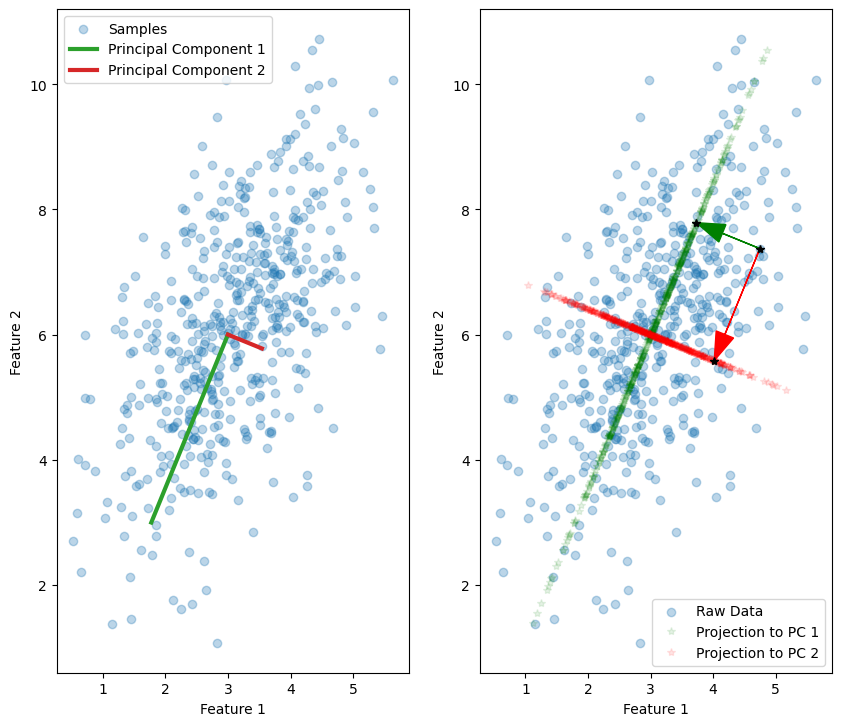

In [5]:
X = utils.generate_data(mean=[3,6], cov=[[1, 1], [1, 3]], n_samples=500)
utils.visualize_data(X, mean=[3,6])

Principal Components Analysis (PCA)
---

PCA stands for [principal components analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) This is often used as an unsupervised dimensionality reduction technique, and by itself does not provide a predictive model.  Regression or classification is often performed in the reduced space afterwards.  PCA is the first step in a number of authentication models like SIMCA.

PCA essentially finds the directions that maximize the covariance of mean-centered X ($\sim X^TX$ **up to a normalizing constant**), then projects the data into a lower dimension space made of the top eigenvectors.  The "top" eigenvectors are determined by the magnitude of the eigenvalue.  These represent the orthogonal directions in space that describe most of the data variation

Before performing PCA we (column-wise) center the data on the mean which is critical so that the eigenvectors "start" at the center of the data "cloud" and extend outward capturing how the data is distributed.  In fact, in sklearn's implementation of PCA the data is always internally centered in case the user forgot to do this! Data that is always centered will not be affected. Note that PCA is "unsupervised" which means we won't be using $Y$, and therefore we don't need to worry about those values. PCA is also **sensitive to data scaling**, so X must be standardized, or autoscaled, if features were measured on different scales (in different units) and we want to assign equal importance to all features. 

Basic steps:

1. Mean center $X$, where $X$ has shape $n \times p$. (optionally also scale the data)

2. Build covariance matrix, $cov(X^T) = X^TX / (n-1)$. Sometimes $n$ not $n-1$ is used.

3. Find unit eigenvectors and eigenvalues, sorted from largest to smallest.

4. Project $T = XW$, where $W$'s columns are the top $k$ eigenvectors so that W has the shape $p \times k$.

$T$ is refered to as the "scores" matrix and represents the projection (compression) of the data; $W^T$ is related to the "loadings" matrix.

In general, if we create a model of some data like:

$$X = TP^T + E$$

then $T$ is the **"scores" matrix** and $P$ is related to the **"loading" matrix.** Eigenvectors are often scaled to unit vectors so you will see this multiplied by the square root of the eigenvalues to restore their "size" (as in the link above). This is a nice [graphical explanation](https://stats.stackexchange.com/questions/119746/what-is-the-proper-association-measure-of-a-variable-with-a-pca-component-on-a/119758#119758).  These are referred to as "loadings".

A helpful definition of the [loading matrices](https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another) can be found on stackexchange. For PCA the $P$ matrix is composed of the orthonormal eigenvectors. Recall that an orthonormal matrix (columns and rows are orthonormal), $A$, has the property that $AA^T = I$; thus, $A^{-1}AA^T = A^{-1}I$ or $A^T = A^{-1}$.  Since the inverse is equal to its transpose, clearly the above expressions (ignoring error term) we can be rearranged to look like $T = XP$.   

In [6]:
X_std = CorrectedScaler(
    with_mean=True, # Center the data
    with_std=False # But, in this example we will not scale it
).fit_transform(X)

In [7]:
np.cov(X_std.T) # equivalent to np.matmul(X_std.T, X_std) / (X.shape[0] - 1)

array([[0.96555077, 0.92865374],
       [0.92865374, 2.86378176]])

In [8]:
evals, evecs = np.linalg.eig(np.cov(X_std.T)) # Eigenvectors are columns of evecs
ordered = sorted(zip(evals, evecs.T), key=lambda x:x[0], reverse=True)

for i, (eval_, evec_) in enumerate(ordered):
    print('PC {} : Eigenvalue = {}, Normalized Eigenvector = {}'.format(i+1, '%.3f'%eval_, evec_))

PC 1 : Eigenvalue = 3.243, Normalized Eigenvector = [-0.37764429 -0.92595075]
PC 2 : Eigenvalue = 0.587, Normalized Eigenvector = [-0.92595075  0.37764429]


In [9]:
# Manually project to a new coordinate along PC 1 - these are the "scores"
T = np.matmul(X_std, ordered[0][1])

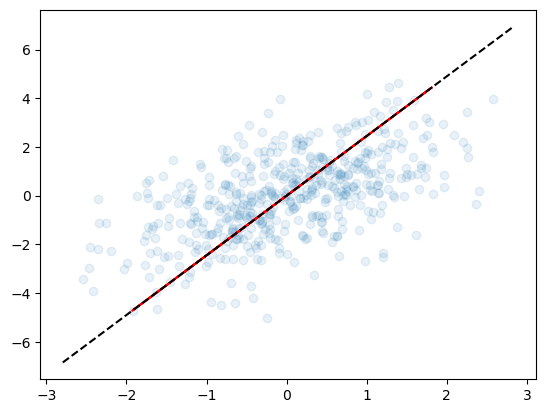

In [10]:
# Visualize projection onto longest semi-axis (=top eigenvector)
X_proj = T.reshape(-1,1)*ordered[0][1]
plt.plot(X_proj[:,0], X_proj[:,1], 'r') # Axes we projected onto in red
plt.scatter(X_std[:,0], X_std[:,1], alpha=0.1)
utils.add_line([0, ordered[0][1][1]/ordered[0][1][0]]) # Plot top eigenvector in black

In [11]:
# Use sklearn to do PCA
pca = PCA(n_components=1)
_ = pca.fit(X_std)

In [12]:
# You can get the scores from sklearn easily
sklearn_scores = pca.transform(X_std) # np.matmul(X_std, pca.components_.T)

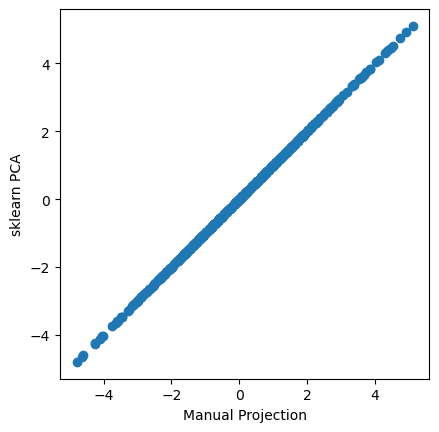

In [13]:
# Note that the sign of the eigenvectors is liable to swap randomly.  This does not affect things practically
# but it can lead to difference is the apparent projection "direction".
plt.plot(
    T, 
    sklearn_scores,
    'o'
)
_ = plt.gca().set(aspect='equal', xlabel='Manual Projection', ylabel='sklearn PCA')

In [14]:
# You can extract the top k eigenvalues from PCA like this.
pca.explained_variance_

array([3.24252845])

In [15]:
# These are the unit eigenvectors (each row)
pca.components_

array([[-0.37764429, -0.92595075]])

In [16]:
# These are the "loadings"
(pca.components_.T*np.sqrt(pca.explained_variance_)).T

array([[-0.68002491, -1.66736156]])

<h3>Relationship to SVD</h3>

You can use [singular value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) to do PCA manually, as well.

In [17]:
# A baseline matrix
a = np.array(
[
    [1, 2],
    [0, 1],
    [3, 6]
])

# Another matrix to use
b = np.array(
[
    [4, 5],
    [0, 2],
    [0, -3]
])

ss = CorrectedScaler(with_std=False) # We need to center this to compare to sklearn's PCA since it does this behind the scenes automatically
a = ss.fit_transform(a)

a

array([[-0.33333333, -1.        ],
       [-1.33333333, -2.        ],
       [ 1.66666667,  3.        ]])

In [18]:
# Let's fit the matrix a
pca = PCA()
pca.fit(a)

pca.components_

array([[ 0.49806073,  0.86714215],
       [ 0.86714215, -0.49806073]])

In [19]:
# Let's project b onto the principal components of a; equivalent to pca.transform(b)
np.matmul(b, pca.components_.T)

array([[ 6.32795367,  0.97826498],
       [ 1.73428431, -0.99612145],
       [-2.60142646,  1.49418218]])

In [20]:
# Let's do a SVD on a to compare
u, s, vh = np.linalg.svd(a)

In [21]:
u, s, vh

(array([[-0.23959124,  0.78055282,  0.57735027],
        [-0.55618295, -0.59776851,  0.57735027],
        [ 0.79577419, -0.18278431,  0.57735027]]),
 array([4.31218769, 0.26777604]),
 array([[ 0.49806073,  0.86714215],
        [ 0.86714215, -0.49806073]]))

In [22]:
# Singular values are the same
np.allclose(pca.singular_values_, s)

True

In [23]:
# The PCA eigenvectors are the same as v
np.allclose(pca.components_, vh)

True

In [24]:
# Since vh is orthonormal, vh^T = vh^-1
np.allclose(vh.T, np.linalg.inv(vh))

True

In [25]:
# In general, you can reconstruct a matrix from u, s, and vh like this:

rank = 2 # Rank of a matrix
np.allclose(a, np.dot(u[:,:rank]*s, vh))

True

In [26]:
# Multiplying wth v can be used to project, or transform, other vectors onto a's principal components
np.allclose(pca.transform(b), np.dot(b, vh))

True

In [27]:
# Note u[:,:rank]*s gives the projection of a onto v.
np.allclose(pca.transform(a), u[:,:rank]*s)

True

In [28]:
# Hence, a_reconstructed = np.dot(u[:,:rank]*s, v)
np.allclose(pca.inverse_transform(pca.transform(a)), np.dot(u[:,:rank]*s, vh))

True

<h3>About That Normalization Factor...</h3>

Some implementations of PCA compute things differently. Sometimes, the eigendecomposition is performed on the $X^TX$ matrix, not the covariance matrix $cov(X^T) = X^TX/(n-1)$.  The unit eigenvectors are unaffected by this missing $(n-1)$ factor, but it does change the eigenvalues by a constant scaling factor (equal to $n-1$).  If you are comparing results from different packages, it is important to keep this in mind.

In [29]:
eigval, eigvec = np.linalg.eig(np.matmul(X_std.T, X_std))
pca = PCA(n_components=2).fit(X_std) # Uses the covariance matrix

In [30]:
# np.linalg.eig returns eigval and eigvec ordered based on eigenvalues from low to high, where the columns are the 
# eigenvectors.  To make this comparable to the PCA, take the transform and reverse the order.
eigvec.T[::-1]

array([[-0.37764429, -0.92595075],
       [-0.92595075,  0.37764429]])

In [31]:
# The first rows are are identical and the second are the same up to a sign change, which is permissable.
# PCA sorts the eigenvectors (each row) based on eigenvalue from high to low.
pca.components_ 

array([[-0.37764429, -0.92595075],
       [ 0.92595075, -0.37764429]])

In [32]:
# You have to account for this scaling when comparing eigenvalues.
# Note that this affects the calculation of the loadings; however, it is simply a constant scaling factor.
np.allclose(
    pca.explained_variance_,
    eigval[::-1] / (X_std.shape[0]-1)
)

True

Principal Components Regression (PCR)
---

[Principle component regression (PCR)](https://en.wikipedia.org/wiki/Principal_component_regression) is essentially just a combination of PCA and OLS.  That is, we perform PCA to project X into a lower dimensional score space, then regress those scores about the target variable.  

This can be summarized in 3 steps:

1. Center the $X$ data for PCA,

2. Project data into lower dimensional space via PCA,

    $$X = TP^T + E_x$$

3. Fit the transformed data with linear regression, including an intercept term because $Y$ is not necessarily centered.  As discussed in OLS, a column of "1"s should be added as the first column in $T$ to account for the intercept term if $Y$ is not centered.

   $$Y = TQ + E_y$$
   
   $$Q = (T^TT)^{-1}T^TY$$

The final model that makes predictions is roughly: $\hat{Y} = TQ = (XP)Q$ (but not exactly because $XP$ has a column added manually - if no intercept is used this is exact).

PCA searches for the dimensions representing the highest degree of data variability in an unsupervised way.  However, if the response variable is not correlated with the natural "spatial" variability in its regressors, $X$, then PCA will reduce the predictive ability of the model. 

From Wikipedia: "In general, PCR is essentially a shrinkage estimator that usually retains the high variance principal components as covariates in the model and discards the remaining low variance components. Thus it exerts a discrete shrinkage effect on the low variance components nullifying their contribution completely in the original model. In contrast, the ridge regression estimator exerts a smooth shrinkage effect through the regularization parameter inherently involved in its construction. While it does not completely discard any of the components, it exerts a shrinkage effect over all of them in a continuous manner so that the extent of shrinkage is higher for the low variance components and lower for the high variance components. [Frank and Friedman (1993)](https://doi.org/10.1080%2F00401706.1993.10485033) conclude that for the purpose of prediction itself, the ridge estimator, owing to its smooth shrinkage effect, is perhaps a better choice compared to the PCR estimator having a discrete shrinkage effect."

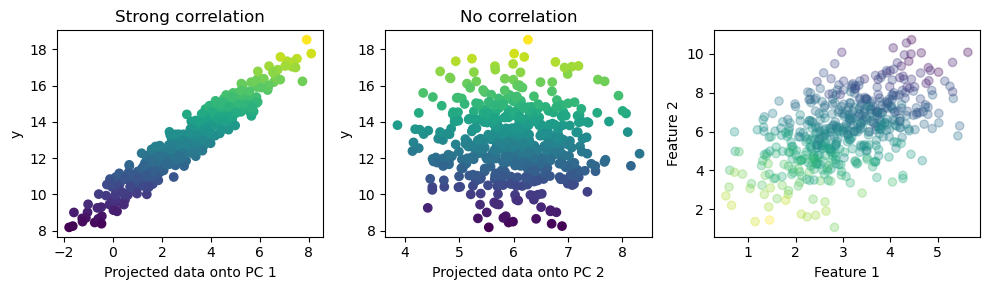

In [33]:
# For this example, we will generate a response correlated with the first eigenvector (PC 1)
y, pca_gen = utils.generate_response(X, 0, mean=[3,6], seed=1, y_center=10, display=True) 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

As you can see the value of y is **strongly correlated with PC1 and not at all with PC2**. This is important since PC1
will be a good predictive variable and we can identify it using PCA.  Adding the second component will not really improve the
PCR model because PC2 is not correlated with y.

In [34]:
def fit_pcr(n_components):
    # 1. Standardize X
    # 2. Do PCA in standardized X space
    # 3. Fit line (with intercept) to projected space
    pcr = imblearn.pipeline.Pipeline(steps=[
        ("autoscale", CorrectedScaler(with_mean=True, with_std=False)), 
        ("pca", PCA(n_components=n_components)), 
        ("regress", LinearRegression(fit_intercept=True))
    ])

    # Let's center this to show that the intercept will come out to be 0
    y_scaler = CorrectedScaler(with_mean=True, with_std=False)
    pcr.fit(X_train, y_scaler.fit_transform(y_train.reshape(-1,1)))

    plt.plot(y_scaler.transform(y_test.reshape(-1,1)), pcr.predict(X_test), 'o')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    _ = plt.title(r'$R^2=${}'.format(
        '%.3f'%pcr.score(
            X_test, 
            y_scaler.transform(y_test.reshape(-1,1))
        )
    ))
    
    return pcr

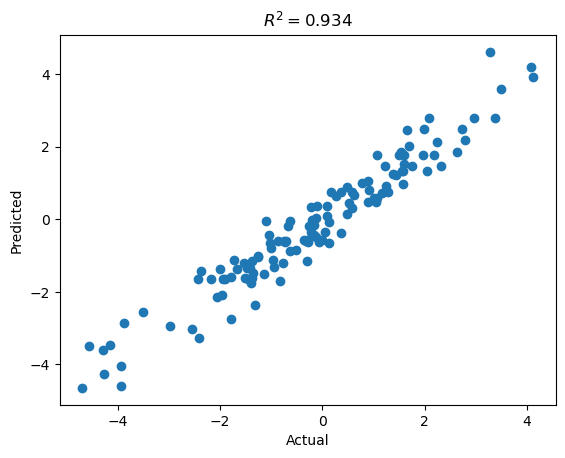

In [35]:
pcr = fit_pcr(n_components=1)

In [36]:
pcr.named_steps['regress'].intercept_ # Indeed, the intercept comes out to be ~zero

array([-1.364707e-15])

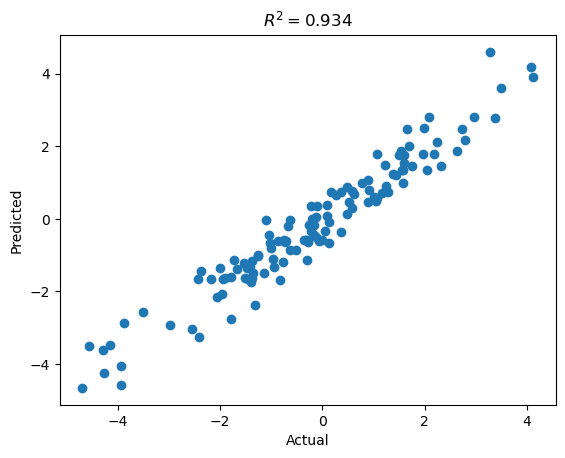

In [37]:
# Adding the second component does not improve the model.
pcr = fit_pcr(n_components=2) 

What if we correlate the y value with PC2 instead?  Now using PCA to select only PC1 for regression will actually remove all predictive information!

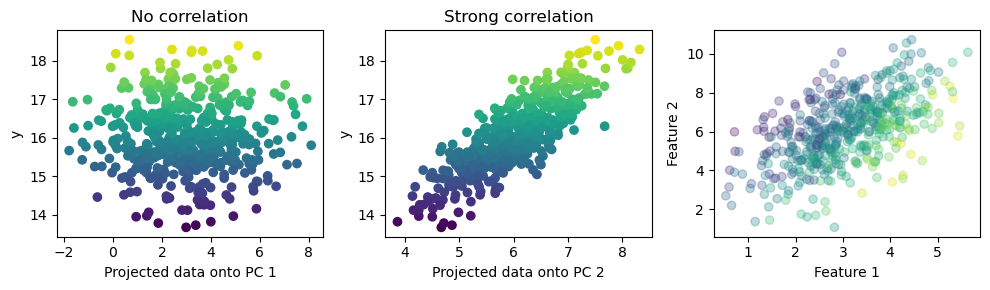

In [38]:
y, pca_gen = utils.generate_response(X, 1, mean=[3,6], seed=1, y_center=10, display=True) 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

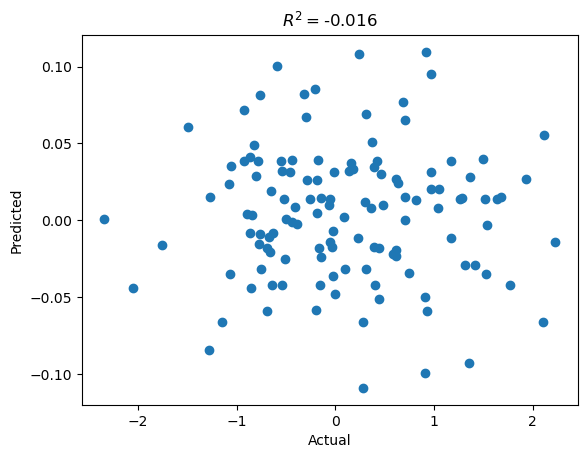

In [39]:
# A 1 component model is basically worthless!
pcr = fit_pcr(n_components=1)

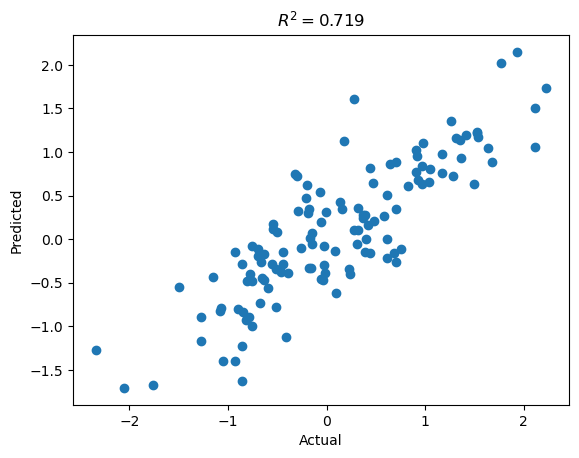

In [40]:
# Adding the second component adds predictive information back into the model.
pcr = fit_pcr(n_components=2)